In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from asymmetric_laplacian_distribution import generate_ALF_data, get_index_per_class, get_labels, labels_to_layout_mapping
import functions_for_plotting 
from prediction_strength import get_statistic_score_per_k
from training_set_split import get_training_folds
from spectral_clustering import spectral_clustering
import prediction_strength
from matplotlib.legend import Legend
import wagenaar_dataset
from prediction_strength import calculate_centroids_and_predict_validation_data

/Users/paule/anaconda3/envs/bon17/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Dataset
- load dataset
- load culture dict specifiying for each culture start and end point with respect to the dataset for indexing

In [176]:
data_dir = "data/raw_data/daily_spontanous_dense/culture2_over_days/"
data = np.load(data_dir + "data_burst_by_time_culture_2_2.npy").T
culture_dict = np.load(data_dir + "culture_dict_culture_2_2.npy", allow_pickle=True).item()

## Specify Data Splitting
split styles: 
- 'balanced' with respect to cultures (5 fold random split for each culture) --> culture_dict must be provided
- 'random' 5 fold random split --> no culture_dict needed
- 'unbalanced' some clusters only occure in training fold not in validation fold --> culture_dict and only_training_clusters (list of cluster per fold which should only be occur in training data) 

In [25]:
split_style = "balanced"
folds = 5

In [26]:
train_fold_indices, valid_fold_indices = training_set_split.get_training_folds(data,culture_dict,cluster_split = split_style,folds = folds)

# Labels

In [27]:
labels_total = np.load("labels_culture_2_2_Euclidean_k=10_reg=none_100clusters.npy" , allow_pickle = True)
labels_four_fifth = np.load("labels_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_train_100clusters.npy" ,  allow_pickle = True)
labels_one_fifth = np.load("labels_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_valid_100clusters.npy" ,  allow_pickle = True)

# Jackknife Cross Validation

## Centroid Predictions

In [ ]:
def get_labels_centroid_predicted(data, test_fold_indices, train_fold_indices, labels_train):
    labels_centroid_predicted = []
    for f, test_idx in enumerate(test_fold_indices):
        train_data = data[train_fold_indices[f]]
        test_data = data[test_idx]
        labels_predicted_f = []
        for k in range(len(labels_train[f])):
            if k == 0:
                predictions=np.zeros(len(test_data))
            else:
                _, predictions = calculate_centroids_and_predict_validation_data(train_data, labels_train[f][k], test_data)
            labels_predicted_f.append(predictions)
        labels_centroid_predicted.append(labels_predicted_f)
    return labels_centroid_predicted

def get_labels_in_total(test_fold_indices, labels_total):
    labels_in_total = []
    for f, test_idx in enumerate(test_fold_indices):
        labels_in_total_f = []
        for k in range(len(labels_total)):
            labels_in_total_f.append(labels_total[k][test_idx])
        labels_in_total.append(labels_in_total_f)
    return labels_in_total

In [ ]:
labels_one_fifth_centroid_predicted  = get_labels_centroid_predicted(data, valid_fold_indices, train_fold_indices, labels_four_fifth)
labels_four_fifth_centroid_predicted = get_labels_centroid_predicted(data, train_fold_indices, range(len(data)), labels_total)
labels_one_fifth_in_total = get_labels_in_total(valid_fold_indices,labels_total)


#np.save("labels_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_labels_one_fifth_centroid_predicted.npy"  ,labels_one_fifth_centroid_predicted_i)
#np.save("labels_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_labels_four_fifth_centroid_predicted.npy" ,labels_four_fifth_centroid_predicted_i)
#np.save("labels_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_labels_one_fifth_in_total.npy" ,labels_one_fifth_in_total_i)

## Cross Validation F1-Scores

In [ ]:
#scores: F1, Precision, Recall, Confusion Matrix(true_positives, false_positives, true_negatives, false_negatives)
def cross_validate_data(data, train_fold_indices, valid_fold_indices,
                        labels_valid, labels_train, clusterwise, true_scores = False ,statistic="F1"):
    scores_folds = {}
    for k in range(1,101):
        scores_folds[k] = []
    
    for i in range(len(labels_valid)):
        clustered_labels_valid = {}
        clustered_labels_train = {}
        for k in range(len(labels_valid[i])):
            clustered_labels_valid[k+1] = labels_valid[i][k]
            clustered_labels_train[k+1] = labels_train[i][k]
        
        if statistic == "PS":
            score,_ = prediction_strength.get_prediction_strength_per_k(data, train_fold_indices[i], valid_fold_indices[i], clustered_labels_train, clustered_labels_valid)
        else:
            if true_scores:
                score = prediction_strength.get_statistic_score_per_k(data, train_fold_indices[i], valid_fold_indices[i], clustered_labels_train, clustered_labels_valid,combination_type = "true", true_train_labels = true_labels[valid_fold_indices[i]], clusterwise = clusterwise, statistic=statistic)
            else:
                score = prediction_strength.get_statistic_score_per_k(data, train_fold_indices[i], valid_fold_indices[i], clustered_labels_train, clustered_labels_valid,combination_type = "training (equal)", clusterwise = clusterwise, statistic=statistic)
            
            
        for k in range(1,101):
            scores_folds[k].append(score[k]) 
    return scores_folds

In [ ]:
statistic = "F1"

for clusterwise in [False, True]:
    scores_folds = {}
    for k in range(1,len(labels_one_fifth_centroid_predicted[0])+1):
        scores_folds[k] = []

    for i in range(len(labels_one_fifth_centroid_predicted)):
        clustered_labels_valid_predicted = {}
        clustered_labels_valid_in_total = {}

        for k in range(len(labels_one_fifth_centroid_predicted[i])):
            clustered_labels_valid_predicted[k+1] = labels_one_fifth_centroid_predicted[i][k]
            clustered_labels_valid_in_total[k+1] = labels_one_fifth_in_total[i][k]

        score = prediction_strength.get_statistic_score_per_k(data, None, valid_fold_indices[i], None, clustered_labels_valid_predicted, combination_type = "true", true_train_labels = clustered_labels_valid_in_total, clusterwise = clusterwise, statistic=statistic)

        for k in range(1,len(labels_one_fifth_centroid_predicted[0])+1):
                scores_folds[k].append(score[k])    
    if clusterwise:
        np.save("F1_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_train_100clusters_jackknife_one_fifth_centroid_vs_total_clusterwise", scores_folds)
    else:
        np.save("F1_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_train_100clusters_jackknife_one_fifth_centroid_vs_total"  , scores_folds)


for clusterwise in [False, True]:

    scores_folds = {}
    for k in range(1,len(labels_four_fifth_centroid_predicted[0])+1):
        scores_folds[k] = []

    for i in range(len(labels_four_fifth_centroid_predicted)):
        clustered_labels_train_predicted = {}
        clustered_labels_train = {}

        for k in range(len(labels_four_fifth_centroid_predicted[i])):
            clustered_labels_train_predicted[k+1] = labels_four_fifth_centroid_predicted[i][k]
            clustered_labels_train[k+1] = labels_four_fifth[i][k]

        score = prediction_strength.get_statistic_score_per_k(data, None, train_fold_indices[i], None, clustered_labels_train, combination_type = "true", true_train_labels = clustered_labels_train_predicted, clusterwise = clusterwise, statistic=statistic)

        for k in range(1,len(labels_one_fifth_centroid_predicted[0])+1):
                scores_folds[k].append(score[k])  

    if clusterwise:
        np.save("F1_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_train_100clusters_jackknife_four_fifth_separate_vs_total_centroid_clusterwise" , scores_folds)
    else:
        np.save("F1_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_train_100clusters_jackknife_four_fifth_separate_vs_total_centroid", scores_folds)

## Plot Scores

In [2]:
score_dict = ""#"WagenaarData/Day20/Jackknife_Method/F1-Scores/"

In [3]:
score_files = [score_dict+ 'F1_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_train_100clusters_jackknife_one_fifth_centroid_vs_total.npy',
              score_dict +'F1_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_train_100clusters_jackknife_one_fifth_centroid_vs_total_clusterwise.npy',
              score_dict +'F1_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_train_100clusters_jackknife_four_fifth_separate_vs_total_centroid.npy',
              score_dict +'F1_culture_2_2_Euclidean_k=10_reg=None_5_fold_balanced_train_100clusters_jackknife_four_fifth_separate_vs_total_centroid_clusterwise.npy']

In [4]:
scores = []
for file in score_files:
    scores.append(np.load(file,allow_pickle=True).item())

In [5]:
keys = ["F1-Score: 1/5 centroid vs. total separate",
        "F1-Score: 1/5 centroid vs. total separate (clusterwise)",
        "F1-Score: 4/5 separate vs. total centroid",
       "F1-Score: 4/5 separate vs. total centroid (clusterwise)"] 

In [6]:
figsize=(20,10)
plot_adjustments = [0.05,0.08,0.95, 0.86]
save_file = "Scores_culture_2_2_Euclidean_k=10_reg=None_weighting=False_5_fold_random_100clusters_jackknife.pdf"
title = "Mean Scores of clusters found in a 5 fold culture balanced split \n Wagenaar Culture 2.2 Dataset with jackknife method (averaged over folds) \n reg=None"

1
0
0
0


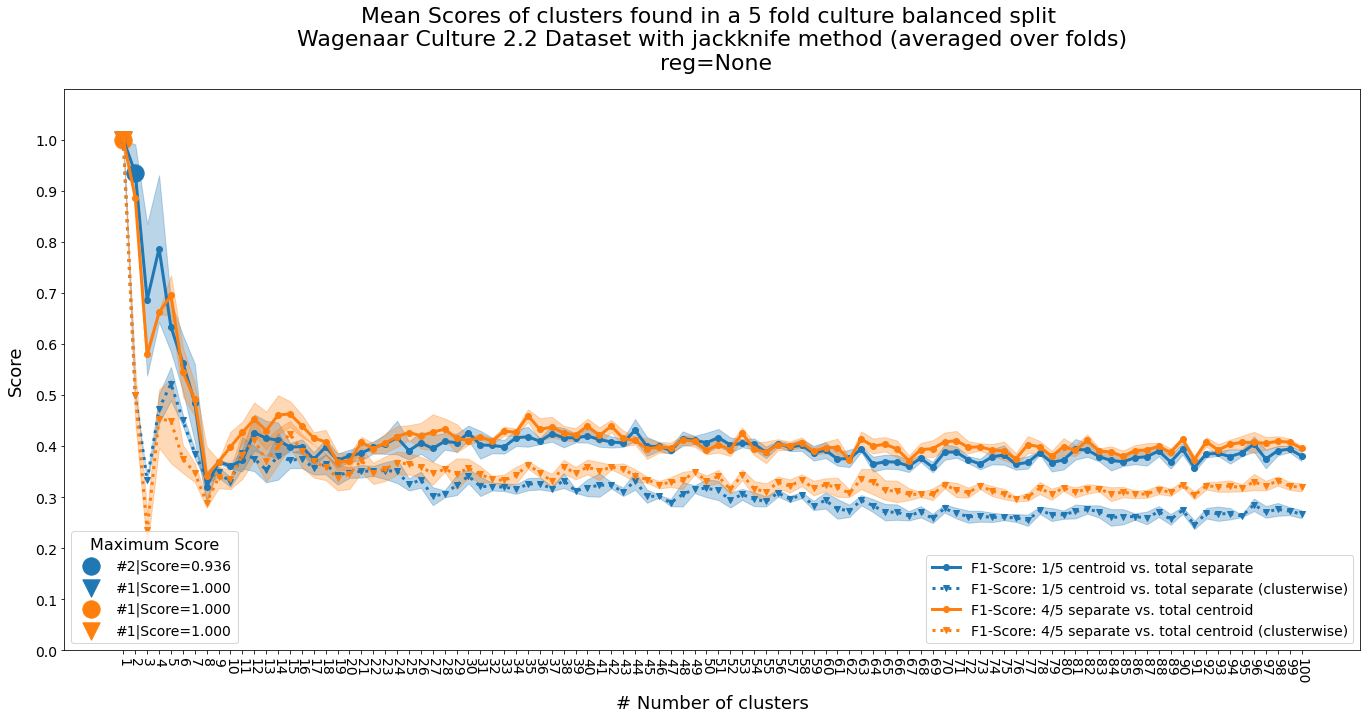

In [8]:
fig, ax = plt.subplots(figsize=figsize)
k_clusters = range(1,101)
#k_clusters = range(1,21)

scores_lines = []
scores_max_points = []
scores_max_points_labels = []
for i,key in enumerate(keys):
    scores_key = scores[i]
    
    mean_scores_k = []
    for k in list(scores_key.keys()):
        if len(np.asarray(scores_key[k]).shape) == 1:
            mean_scores_k.append(scores_key[k])
        else:
            mean_scores_k.append(np.mean(scores_key[k], axis=1))

    mean_fold_scores = np.mean(mean_scores_k,axis=1)
    std_fold_scores = np.std(mean_scores_k,axis=1)
    
    argmax_scores=np.argmax(mean_fold_scores)
    
    skip_trivial_solution_max = np.argmax(mean_fold_scores[1:]) + 1 
    if mean_fold_scores[skip_trivial_solution_max] >= 0.9:
        argmax_scores = skip_trivial_solution_max

        
    print(argmax_scores)
    
    if "clusterwise" in key: 
        scores_lines += ax.plot(k_clusters, mean_fold_scores, "v:", label=key, color = "C0%d" % (i//2),linewidth=3)
        scores_max_points += [ax.scatter(k_clusters[argmax_scores], mean_fold_scores[argmax_scores], color = "C0%d"  % (i//2), marker="v",s=300)]
    else:
        scores_lines += ax.plot(k_clusters, mean_fold_scores, "o-", label=key, color = "C0%d" % (i//2),linewidth=3)
        scores_max_points += [ax.scatter(k_clusters[argmax_scores], mean_fold_scores[argmax_scores], color = "C0%d"  % (i//2), marker="o",s=300)]
    scores_max_points_labels +=  ["#%d|Score=%.3f" % (argmax_scores+1, mean_fold_scores[argmax_scores])]
    plt.fill_between(k_clusters, mean_fold_scores-std_fold_scores, mean_fold_scores+std_fold_scores, alpha=.3, color = "C0%d"  % (i//2))
    
    

ax.set_title(title, fontsize=22, pad=20)
ax.set_xticks(k_clusters)
ax.set_xlabel("# Number of clusters", fontsize=18, labelpad=10)
ax.set_ylabel("Score", fontsize=18, labelpad=10),
ax.set_ylim((0, 1.1))
#ax.set_ylim((0, 1000000))
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14,rotation=-90)

ax.set_yticks(np.arange(0, 1.1,0.1))
left = plot_adjustments[0]
bottom = plot_adjustments[1]
right = plot_adjustments[2]
top = plot_adjustments[3]

plt.subplots_adjust(left,bottom,right, top)

ax.legend(scores_lines, keys,fontsize = 14, loc="lower right")
leg = Legend(ax, scores_max_points,scores_max_points_labels,fontsize = 14, loc="lower left", title = "Maximum Score", )
leg.get_title().set_fontsize('16')
ax.add_artist(leg)
plt.savefig(save_file)

## Plot Validation and Training clusterings

In [38]:
clustered_labels_one_fifth_in_total = {}
clustered_labels_one_fifth_centroid_predicted = {}
clustered_labels_four_fifth = {}
clustered_labels_four_fifth_centroid_predicted = {}
clustered_labels_total = {}


for i in range(len(labels_one_fifth_in_total[0])):
    clustered_labels_one_fifth_in_total[i+1] = np.asarray(labels_one_fifth_in_total)[:,i]
    clustered_labels_one_fifth_centroid_predicted[i+1] = np.asarray(labels_one_fifth_centroid_predicted)[:,i]
    clustered_labels_four_fifth[i+1] = np.asarray(labels_four_fifth)[:,i]
    clustered_labels_four_fifth_centroid_predicted[i+1] = np.asarray(labels_four_fifth_centroid_predicted)[:,i]
    clustered_labels_total[i+1] = np.asarray(labels_total)[i]

In [ ]:
save_file_clusters = "test.pdf"
k_clusters = 10
reference_clusters = 10
title = ""

In [ ]:
rows = 3
columns = 4
figsize = (20,20)
subplot_adjustments = [0.05,0.95,0.03,0.9,0.4, 0.15]

In [ ]:
# Validation 
functions_for_plotting.plot_clusters(data[valid_fold_indices[0]], # the dataset 
                                     true_labels[valid_fold_indices[0]], # the reference labels for the dataset 
                                     clustered_labels_one_fifth_in_total[k_clusters][0],  # the clustered labels 
                                     rows, # the number of rows in the grid 
                                     columns, # the number of columns in the grid 
                                     None, # our layout mapping 
                                     figsize=figsize, # the figsize
                                     reference_clustering="F1-Score",
                                     scores = F1_scores[k_clusters][0],
                                     n_bursts = 100, # the number of bursts you want to plot for each cluster 
                                     y_lim = (0,16), # the y_lim for zoomed plot (0,1) normal (0,16)
                                     save_file=save_file_clusters, # the file you want to save the plot 
                                     subplot_adjustments= subplot_adjustments, # adjustments for suplots and overall spacing (tricky) 
                                     plot_mean=False, # plot the mean of each cluster ? 
                                     title= title )# title of the plot     

In [ ]:
# training
functions_for_plotting.plot_clusters(data[train_fold_indices[0]], # the dataset 
                                     true_labels[train_fold_indices[0]], # the reference labels for the dataset 
                                     clustered_labels_train[k_clusters][0],  # the clustered labels 
                                     rows, # the number of rows in the grid 
                                     columns, # the number of columns in the grid 
                                     None, # our layout mapping 
                                     figsize=figsize, # the figsize
                                     reference_clustering="True",
                                     scores = None,
                                     n_bursts = 100, # the number of bursts you want to plot for each cluster 
                                     y_lim = (0,16), # the y_lim for zoomed plot (0,1) normal (0,16)
                                     save_file=save_file_clusters, # the file you want to save the plot 
                                     subplot_adjustments= subplot_adjustments, # adjustments for suplots and overall spacing (tricky) 
                                     plot_mean=False, # plot the mean of each cluster ? 
                                     title= title)# title of the plot 